## **Credit Card Fraud Detection with Pyspark**

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [1]:
import kagglehub
path = kagglehub.dataset_download("ealaxi/paysim1")

Using Colab cache for faster access to the 'paysim1' dataset.


In [2]:
import os

# List files in the downloaded dataset directory
print(f"Files in {path}:")
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in /kaggle/input/paysim1:
/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [3]:

spark = SparkSession.builder.master("local[*]").appName("FraudDetection").getOrCreate()

In [4]:
df = spark.read.csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv",header=True,inferSchema=True)
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

###**Exploring Fraud vs Legitimate Transactions**

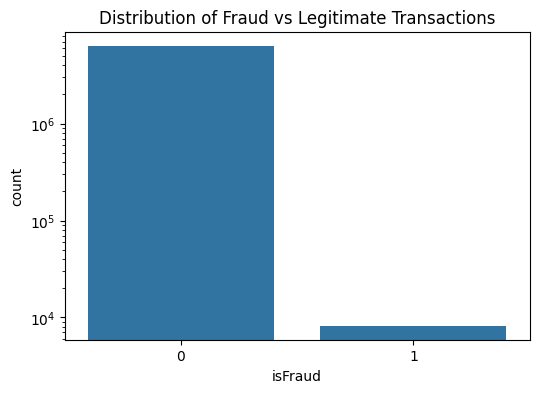

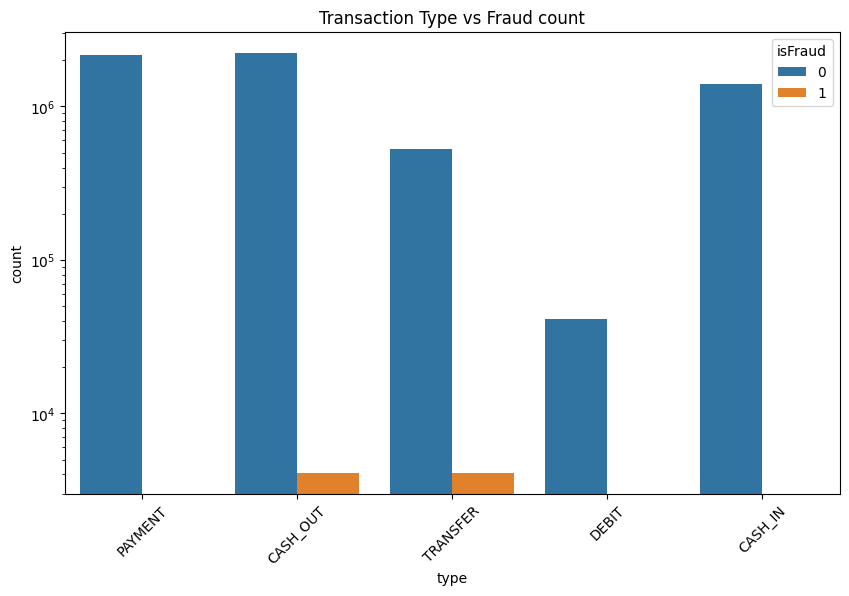

Observation: Notice that fraud only occurs in TRANSFER and CASH_OUT types.


In [6]:
fraud_counts = df.groupBy("isFraud").count().toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x="isFraud", y="count", data=fraud_counts)
plt.title("Distribution of Fraud vs Legitimate Transactions")
plt.yscale('log')
plt.show()


type_fraud = df.groupBy("type", "isFraud").count().toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="type", y="count", hue="isFraud", data=type_fraud)
plt.title("Transaction Type vs Fraud count")
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

print("Observation: Notice that fraud only occurs in TRANSFER and CASH_OUT types.")

### **Feature Engineering** and Data pre-processing

In [8]:
indexer = StringIndexer(inputCol="type", outputCol="typeIndex")


encoder = OneHotEncoder(inputCol="typeIndex", outputCol="typeVec")


feature_columns = ["typeVec", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


pipeline = Pipeline(stages=[indexer, encoder, assembler])
pipeline_model = pipeline.fit(df)
data_transformed = pipeline_model.transform(df)


final_data = data_transformed.select("features", "isFraud")

### Splitting the Original Data for validation

In [13]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

### Undersample imbalanced data

In [11]:
from pyspark.sql.functions import col

fraud_df = final_data.filter(col("isFraud") == 1)
legit_df = final_data.filter(col("isFraud") == 0)


fraud_count = fraud_df.count()
legit_count = legit_df.count()

print(f"Original Data - Fraud: {fraud_count}, Legitimate: {legit_count}")


fraction = float(fraud_count) / legit_count

legit_undersampled = legit_df.sample(withReplacement=False, fraction=fraction, seed=42)


balanced_data = fraud_df.union(legit_undersampled)

print(f"Balanced Data Count: {balanced_data.count()}")
balanced_data.groupBy("isFraud").count().show()

Original Data - Fraud: 8213, Legitimate: 6354407
Balanced Data Count: 16506
+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 8213|
|      0| 8293|
+-------+-----+



### Training the model with balanced Data and validating using Original Data, this avoid Data Leakage

In [14]:
train_bal, test_bal = balanced_data.randomSplit([0.8, 0.2], seed=42)


rf_bal = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=50)
rf_model_bal = rf_bal.fit(train_bal)

predictions_bal = rf_model_bal.transform(test_data)


evaluator_roc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")
print(f"Area Under ROC: {evaluator_roc.evaluate(predictions_bal):.4f}")


predictions_bal.groupBy("isFraud", "prediction").count().show()

Area Under ROC: 0.9953
+-------+----------+-------+
|isFraud|prediction|  count|
+-------+----------+-------+
|      1|       0.0|     79|
|      0|       0.0|1225341|
|      1|       1.0|   1572|
|      0|       1.0|  46144|
+-------+----------+-------+



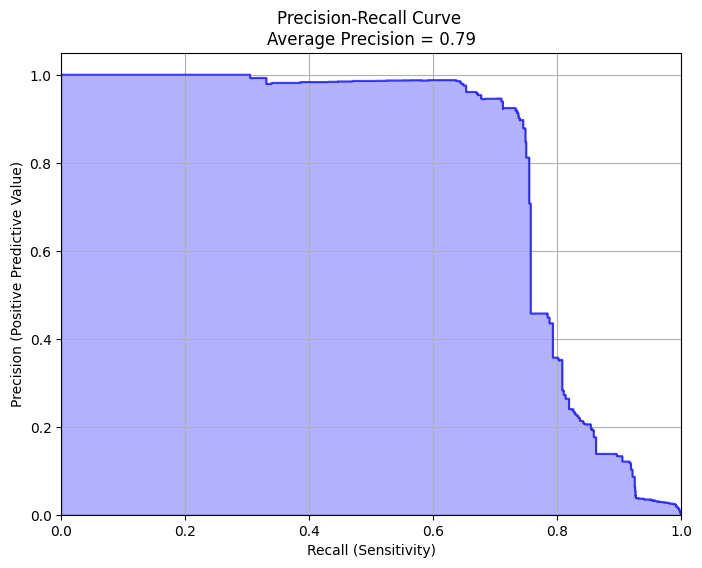

In [17]:
results_pd = predictions_bal.select("isFraud", "probability").toPandas()
results_pd['prob_fraud'] = results_pd['probability'].apply(lambda x: x[1])


precision, recall, thresholds = precision_recall_curve(results_pd['isFraud'], results_pd['prob_fraud'])
avg_precision = average_precision_score(results_pd['isFraud'], results_pd['prob_fraud'])


plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve \nAverage Precision = {avg_precision:.2f}')
plt.grid(True)
plt.show()